In [1]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

sys.path.append("../../../libs/")
#import HEq
import MosaicFitsReader as mfr

In [2]:
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

In [3]:
 def centroid(arr):
    """
    One step 1D centroiding algo.
    Returns centroid position and standard deviation
    """
    l = arr.shape[0]
    ixs = np.arange(l)
    arr = arr - np.median(arr)
    arr = np.where(arr < 0, 0, arr)    
    ixs2 = ixs * ixs
    sumarr = arr.sum()
    cen = np.dot(arr, ixs)/sumarr
    return cen, math.sqrt(np.dot(arr, ixs2)/sumarr - cen * cen)

def centroidLoop(arr, fromIdx, toIdx, nLoops=10, epsilon=1E-1):
    """
    Finds the centroid by repeatedly centering and recalculating 
    until the centroid position changes by less than epsilon.
    
    Returns status, centroid position, standard deviation, iterations
    
    status: 0 OK, -1 bad centroid or no signal
    centroid position: position relative to input array, ie. 0 is first pixel
    standard deviation: standard deviation as calculated by the centroid algorithm (assumed Gaussian stats)
    iterations: number of iterations needed until change is less than epsilon
    """
    def limit(x):
        if x < 0: return 0
        if x >= length: return length
        return x
    
    length = len(arr)
    radius = (toIdx - fromIdx)/2
    lastCenPos = -9999
    for i in range(nLoops):
        fromIdx = int(limit(fromIdx))
        toIdx = int(limit(fromIdx + radius + radius + 0.5))
        pos, cenStd = centroid(arr[fromIdx:toIdx])
        cenPos = pos + fromIdx
        #print (i, fromIdx, toIdx, cenPos, cenStd, lastCenPos)
        
        if cenPos < fromIdx or toIdx < cenPos:
            return -1, 0, 0, i
        
        if abs(lastCenPos - cenPos) < epsilon:
            return 0, cenPos, cenStd, i
        if cenStd > radius/3:
            return -1, cenPos, cenStd, i
        fromIdx = cenPos - radius
        lastCenPos = cenPos
        
    return -1, cenPos, cenStd, i  

In [4]:
def findWidths (arr1d, size=60):
    """
    Divides the input array in segments of size length.
    For each segment, finds the centroid, if centroid is good then record it.
    Sorts the centroids by standard deviation.
    Returns the smallest half of the standard deviation
    """
    out = []
    for x in range(0, len(arr1d)-size, size):
        ok, cen, std, idx = centroidLoop(arr1d, x, x+size)     
        #print (res)
        if ok == 0:
            out.append(std)
    #print (out)
    if len(out) <= 0:
        return []
    out = sorted(out)
    return out[:len(out)//2]

In [5]:
def makePairs(data):
    """
    Input data is in the format: ((focus1, (v1, v2, v3...)), (focus2, (v1, v2, v3)))
    
    Outputs the focus and std as pairs: ((focus1, v1), (focus1, v2), ....)
    """
    for a, b in data:
        for c in b:
            yield (a, c)
            
def calcAsymptote(A, B, C):
    """
    y^2 = Ax^2 + Bx + C
    
    Returns the parameters for the asymptotes for given A, B, C
    """
    h = -B/A/2
    a2 = C - A * h*h
    b2 = a2/A
    m0 = math.sqrt(a2/b2)
    b0 = -m0 * h
    return m0, b0, h

def asympFunc(m, b):
    """
    Returns a function to calculate the asymptote y for given x.
    """
    def f(x):
        return m * x + b
    return f

In [14]:
"""
Shui's version
For all input files, finds the standard deviations of the centroids.
These standard deviations are assosicated with the focus. 

Output is stored in out[].
"""
minrow = 200
maxrow = 3800
out = []
#for f in range(19, 26): #MOS MASK
#    fname = "test_images/mask/bfoc%04d.fits" % f

#for f in range(8,15): #LongSlit blue
#    fname = "test_images/longslit/bfoc%04d.fits" % f
    
for f in range(1,7): #LongSlit red
    fname = "test_images/longslit/rfoc%04d.fits" % f
    
    
    ffile = mfr.MosaicFitsReader(fname)
    img = np.array(ffile.data)
    instrument = ffile.getKeyword('INSTRUME')
    if "BLU" in instrument:
        Focus = ffile.getKeyword('BLUFOCUS')
    else:
        Focus = ffile.getKeyword('REDFOCUS')
    if Focus == None:
        continue
    for row in range(minrow,maxrow,100):
        cut1d = img[:,row]
        if np.max(gaussian_filter(cut1d,sigma=20))> 2000:
            widths = findWidths(cut1d)
            if len(widths)>5:
                clippedWidths,low,upp = stats.sigmaclip(widths,low=4,high=2)
                if clippedWidths.std()<1:
                    print(row,Focus,clippedWidths.mean(),low,upp,clippedWidths.std())
                    out.append((Focus, clippedWidths))


600 -0.75751066 2.87576475943 2.55172746274 3.03778340778 0.0810093241744
700 -0.75751066 2.84977280307 2.6521593591 2.94857952506 0.0494033609932
800 -0.75751066 2.84059971163 2.60925175423 2.95627369033 0.0578369893508
900 -0.75751066 2.95150595567 2.78762488262 3.03344649219 0.0409702682602
1000 -0.75751066 2.95224060136 2.7541201014 3.05130085135 0.0495301249921
1100 -0.75751066 2.97890071893 2.7830864258 3.0768078655 0.0489535732829
1200 -0.75751066 2.95650518147 2.74851066647 3.06050243897 0.0519986287491
1300 -0.75751066 2.78521109009 2.46051391814 2.94755967607 0.0811742929873
1400 -0.75751066 2.95184204928 2.7875151722 3.03400548782 0.0410817192711
1500 -0.75751066 2.9810411794 2.40515035941 3.26898658939 0.143972704998
1600 -0.75751066 3.06382567844 2.27089556976 3.46029073278 0.198232527169
1700 -0.75751066 2.80981955613 2.72439879025 2.85252993907 0.0213551914706
1800 -0.75751066 2.86421956405 2.63282418616 2.979917253 0.0578488444722
1900 -0.75751066 2.86321841904 2.708846

600 -0.55736351 3.08963744111 2.75249320947 3.25820955693 0.084286057911
700 -0.55736351 2.99548158627 2.80171670835 3.09236402524 0.0484412194806
800 -0.55736351 2.93936638928 2.74136790827 3.03836562979 0.0494996202527
900 -0.55736351 2.86774277872 2.75373799927 2.92474516844 0.0285011948615
1000 -0.55736351 2.92030404498 2.62552667168 3.06769273164 0.0736943433265
1100 -0.55736351 2.8675693112 2.69753886462 2.95258453448 0.0425076116429
1200 -0.55736351 2.96856034915 2.65705542763 3.1243128099 0.0778762303782
1300 -0.55736351 3.22672402865 2.66041314583 3.50987947005 0.141577720705
1400 -0.55736351 2.87979641994 2.62693930474 3.00622497753 0.0632142787996
1500 -0.55736351 2.85526799792 2.58884715107 2.98847842134 0.0666052117123
1600 -0.55736351 3.02800604021 2.2581269489 3.41294558587 0.192469772827
1700 -0.55736351 2.95421617702 2.78078451715 3.04093200695 0.043357914968
1800 -0.55736351 3.18007745997 2.76814339725 3.38604449133 0.10298351568
1900 -0.55736351 3.15467931822 2.70837

In [15]:
"""
Prepared values for display and for fitting
"""
pairs = np.array(list(makePairs(out))).T

In [16]:
"""
Fits a hyperbola: x=focus, y=standard deviation

Hyperbola equation: y^2 = Ax^2 + Bx + C

"""
res = np.polyfit(pairs[0], np.multiply(pairs[1], pairs[1]), deg=2)

func = np.poly1d(res)
def func1 (x):
    return math.sqrt(func(x))

funcV = np.vectorize(func1)

"""
Finds the parameters for the asymptotes
"""
A, B, C = res
m0, b0, minX = calcAsymptote(A, B, C)
print ("minX", minX, "Asymp", m0, b0)

minX -0.677668893979 Asymp 14.719157884457209 9.97471544386


<IPython.core.display.Javascript object>


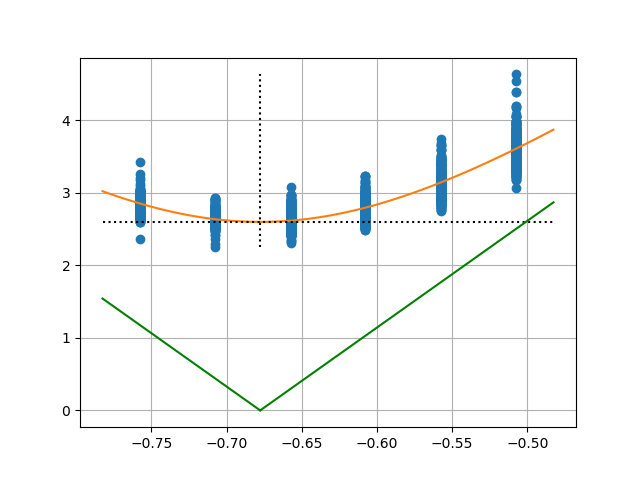

In [17]:
"""
Plots the (focus, std) pairs
"""
plt.plot(pairs[0], pairs[1], 'o')
padding = 10 # this means 10% of the range will be added to each side of the plot

plotRange = max(pairs[0])-min(pairs[0])
x0, x1 = min(pairs[0])-plotRange/100*padding, max(pairs[0])+plotRange/100*padding
#x0, x1 = -4000, -3000 # min(pairs[0]), max(pairs[0])
#x0, x1 = -0.8,-0.5
"""
Plots the fitted hyperbola
"""
xs = np.linspace(x0, x1, 100)
plt.plot(xs, funcV(xs))

"""
Plots a vertical line at best focus and a horizontal line at best focus
"""
plt.plot((x0, x1), (funcV(minX), funcV(minX)), 'k:')
plt.plot((minX, minX), (min(pairs[1]), max(pairs[1])), 'k:')

"""
Plots the asymptotes
"""
posAsymp = asympFunc(m0, b0)
negAsymp = asympFunc(-m0, -b0)

plt.plot((x0, minX), (negAsymp(x0), negAsymp(minX)), 'g-')
plt.plot((minX, x1), (posAsymp(minX), posAsymp(x1)), 'g-')
plt.grid()